### Подключение библиотек 

In [8158]:
import numpy as np
import pandas as pd
import random

In [8159]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [8160]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [8161]:
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [8162]:
import warnings
warnings.filterwarnings('ignore')

In [8163]:
matplotlib.rcParams.update({'font.size': 14})

In [8164]:
from sklearn.model_selection import train_test_split

In [8165]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

### Пути к файлам

In [8166]:
train_df = 'train.csv'
test_df = 'test.csv'
sample_submission = 'sample_submission.csv'

### Загрузка данных

#### Описание датасета

Id - идентификационный номер квартиры
DistrictId - идентификационный номер района
Rooms - количество комнат
Square - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухнии
Floor - этаж
HouseFloor - количество этажей в доме
HouseYear - год постройки дома
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
Social_1, Social_2, Social_3 - социальные показатели местности 
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Price - цена квартиры

In [8167]:
train_df = pd.read_csv(train_df, sep=',')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [8168]:
test_df = pd.read_csv(test_df, sep=',')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [8169]:
test_df.shape

(5000, 19)

#### Разделение Train на train и valid

In [8170]:
X = train_df.drop(columns="Price")
y = train_df["Price"]

In [8171]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

In [8172]:
y_train.head()

4901    219547.192912
4375    346649.424867
6698    205517.003027
9805    126266.883896
1101    260449.038197
Name: Price, dtype: float64

In [8173]:
y_valid.head()

6252    225202.099645
4684    361744.269547
1731    275055.182201
4742    198133.702204
4521    221299.460377
Name: Price, dtype: float64

In [8174]:
print(f"Цена в y_train:\n{y_train}")
print(f"Цена в y_valid:\n{y_valid}")

Цена в y_train:
4901    219547.192912
4375    346649.424867
6698    205517.003027
9805    126266.883896
1101    260449.038197
            ...      
5734    216640.538858
5191    241324.507250
5390    163496.966243
860     128710.472293
7270    109129.982392
Name: Price, Length: 7500, dtype: float64
Цена в y_valid:
6252    225202.099645
4684    361744.269547
1731    275055.182201
4742    198133.702204
4521    221299.460377
            ...      
4862    569110.210440
7025    132719.978752
7647    245221.410716
7161    180051.314011
73      211360.702060
Name: Price, Length: 2500, dtype: float64


In [8175]:
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4901,14277,99,2.0,57.352825,36.375196,9.0,8,14.0,1998,0.033494,B,B,66,10573,1,1322.0,3,8,B
4375,10094,48,3.0,79.705401,47.831885,10.0,15,17.0,1984,0.041125,B,B,46,9515,5,NaN,1,10,B
6698,7580,150,2.0,47.230717,30.442536,6.0,10,12.0,1971,0.020741,B,B,24,5613,5,1340.0,2,5,B
9805,1644,6,1.0,39.147138,38.473125,1.0,17,17.0,2017,0.243205,B,B,5,1564,0,540.0,0,0,B
1101,3606,4,2.0,45.595236,29.986188,5.0,5,5.0,1961,0.042032,B,B,37,6856,84,1940.0,2,5,B


In [8176]:
X_valid.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
6252,3367,3,3.0,101.862701,99.970065,11.0,7,15.0,2013,0.050900,B,B,43,10621,1,30.0,2,3,B
4684,13670,22,1.0,87.485627,NaN,0.0,16,0.0,1977,0.118537,B,B,30,6207,1,1183.0,1,0,B
1731,14507,152,2.0,40.649901,22.288673,7.0,6,9.0,1964,0.042032,B,B,37,6856,84,1940.0,2,5,B
4742,11707,41,1.0,42.909800,20.923332,9.0,14,16.0,1980,0.175055,B,B,36,10055,3,NaN,1,0,B
4521,12298,53,1.0,35.108196,22.155378,9.0,5,12.0,1967,0.049637,B,B,34,7759,0,229.0,1,3,B


In [8177]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [8178]:
X_train.reset_index(inplace = True, drop = True)
y_train = pd.DataFrame(y_train).reset_index(drop = True)

#### Анализ типов данных, целевой переменной, корреляции признаков, пропусков

In [8179]:
X_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [8180]:
X_valid.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [8181]:
test_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [8182]:
X_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,7500.000000,7500.000000,7500.000000,7500.000000,5899.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,3867.000000,7500.000000,7500.000000
mean,8393.933067,50.416133,1.883200,56.123610,36.016750,6.392400,8.452133,12.517200,4.658411e+03,0.117640,24.605733,5332.234533,7.914133,1140.543057,1.311067,4.180933
std,4875.422904,43.718953,0.817341,21.537311,20.010540,32.840241,5.194700,6.717419,2.315178e+05,0.119138,17.562436,4015.545522,23.504289,1025.189260,1.492359,4.760786
min,0.000000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.912000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,4152.750000,19.000000,1.000000,41.665903,22.660693,1.000000,4.000000,9.000000,1.973750e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,8413.500000,36.000000,2.000000,52.328644,32.641537,6.000000,7.000000,12.000000,1.977000e+03,0.072158,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000
75%,12625.250000,75.000000,2.000000,65.745649,45.125018,9.000000,12.000000,17.000000,2.000250e+03,0.194489,36.000000,7227.000000,5.000000,1548.000000,2.000000,5.000000
max,16798.000000,209.000000,10.000000,641.065193,638.163193,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


In [8183]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [8184]:
X_valid.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,2500.000000,2500.000000,2500.000000,2500.000000,1988.000000,2500.000000,2500.000000,2500.0000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,1335.000000,2500.000000,2500.000000
mean,8351.831600,50.354800,1.912400,56.892270,40.709654,5.916000,8.750400,12.8860,1985.431200,0.122511,24.930800,5411.926000,8.414400,1149.744569,1.344800,4.382400
std,4810.302272,43.199771,0.902581,19.545621,168.264857,5.235027,5.372937,6.9427,18.457972,0.118634,17.444074,3980.648735,24.789717,1011.156006,1.497334,4.938373
min,2.000000,0.000000,0.000000,16.547242,0.795539,0.000000,1.000000,0.0000,1910.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000
25%,4210.250000,21.000000,1.000000,42.011032,23.211769,1.000000,4.000000,9.0000,1975.000000,0.033494,8.000000,1892.000000,0.000000,520.000000,0.000000,1.000000
50%,8359.500000,35.500000,2.000000,53.096580,33.034392,6.000000,8.000000,14.0000,1977.000000,0.075779,25.000000,5285.000000,2.000000,920.000000,1.000000,3.000000
75%,12490.500000,74.000000,2.000000,66.520001,45.149650,9.000000,12.000000,17.0000,2002.000000,0.200147,35.000000,7287.000000,5.000000,1548.000000,3.000000,6.000000
max,16785.000000,208.000000,19.000000,212.932361,7480.592129,123.000000,37.000000,99.0000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


In [8185]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             7500 non-null   int64  
 1   DistrictId     7500 non-null   int64  
 2   Rooms          7500 non-null   float64
 3   Square         7500 non-null   float64
 4   LifeSquare     5899 non-null   float64
 5   KitchenSquare  7500 non-null   float64
 6   Floor          7500 non-null   int64  
 7   HouseFloor     7500 non-null   float64
 8   HouseYear      7500 non-null   int64  
 9   Ecology_1      7500 non-null   float64
 10  Ecology_2      7500 non-null   object 
 11  Ecology_3      7500 non-null   object 
 12  Social_1       7500 non-null   int64  
 13  Social_2       7500 non-null   int64  
 14  Social_3       7500 non-null   int64  
 15  Healthcare_1   3867 non-null   float64
 16  Helthcare_2    7500 non-null   int64  
 17  Shops_1        7500 non-null   int64  
 18  Shops_2 

In [8186]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 6252 to 73
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2500 non-null   int64  
 1   DistrictId     2500 non-null   int64  
 2   Rooms          2500 non-null   float64
 3   Square         2500 non-null   float64
 4   LifeSquare     1988 non-null   float64
 5   KitchenSquare  2500 non-null   float64
 6   Floor          2500 non-null   int64  
 7   HouseFloor     2500 non-null   float64
 8   HouseYear      2500 non-null   int64  
 9   Ecology_1      2500 non-null   float64
 10  Ecology_2      2500 non-null   object 
 11  Ecology_3      2500 non-null   object 
 12  Social_1       2500 non-null   int64  
 13  Social_2       2500 non-null   int64  
 14  Social_3       2500 non-null   int64  
 15  Healthcare_1   1335 non-null   float64
 16  Helthcare_2    2500 non-null   int64  
 17  Shops_1        2500 non-null   int64  
 18  Shops_2

In [8187]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Целевая переменная

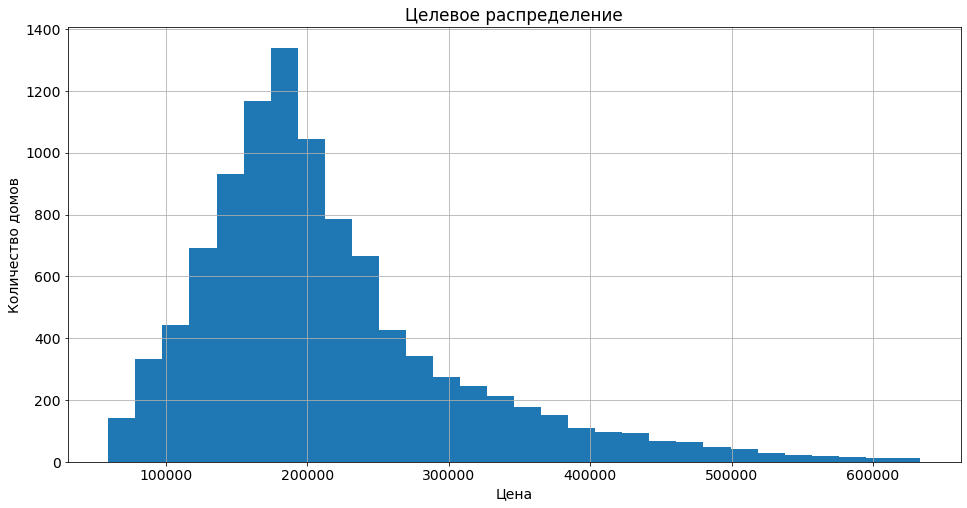

In [8188]:
plt.figure(figsize = (16,8))

train_df['Price'].hist(bins=30)
plt.ylabel('Количество домов')
plt.xlabel('Цена')

plt.title('Целевое распределение')
plt.show()

In [8189]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]
print(f"mean ={target_mean}, median = {target_median}, moda = {target_mode}")

mean =214138.86, median = 192269.64487934904, moda = 59174.77802758122


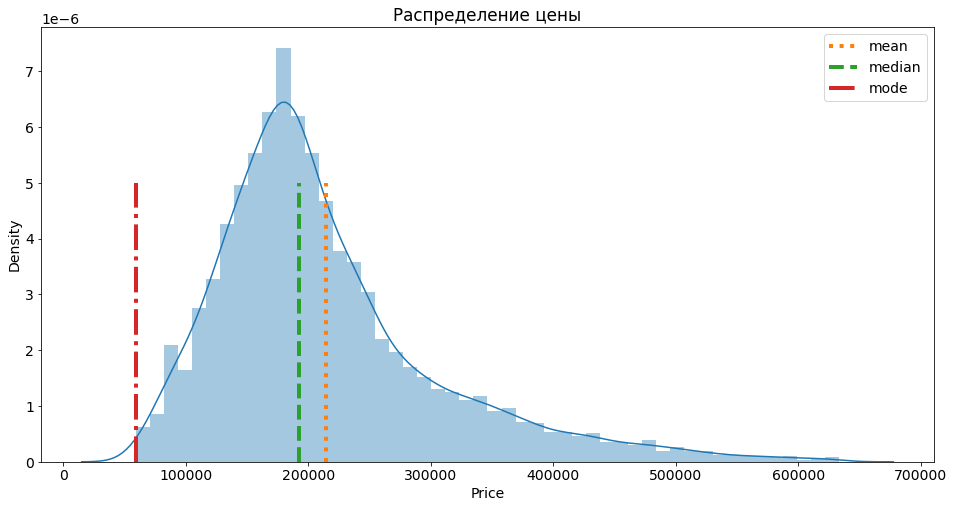

In [8190]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=":", linewidth = 4)
plt.plot([target_median] * 10, y, label='median', linestyle="--", linewidth = 4)
plt.plot([target_mode] * 10, y, label='mode', linestyle="-.", linewidth = 4)

plt.title ('Распределение цены')
plt.legend()
plt.show()

In [8191]:
train_df['Price'].value_counts()

305018.871089    1
250690.485361    1
109180.930270    1
190451.552519    1
268723.157677    1
                ..
282595.048212    1
174164.867390    1
345232.282316    1
162953.431516    1
177685.627486    1
Name: Price, Length: 10000, dtype: int64

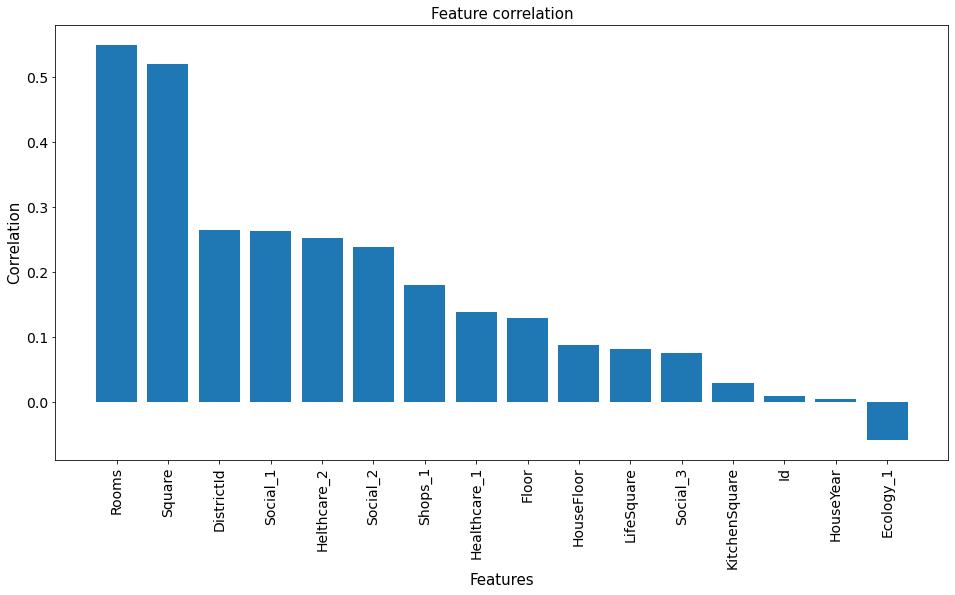

In [8192]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

#### Обзор количественных переменных

In [8193]:
X_train_num_features = X_train.select_dtypes(include=['float64', 'int64'])
X_train_num_features.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,14277,99,2.0,57.352825,36.375196,9.0,8,14.0,1998,0.033494,66,10573,1,1322.0,3,8
1,10094,48,3.0,79.705401,47.831885,10.0,15,17.0,1984,0.041125,46,9515,5,NaN,1,10
2,7580,150,2.0,47.230717,30.442536,6.0,10,12.0,1971,0.020741,24,5613,5,1340.0,2,5
3,1644,6,1.0,39.147138,38.473125,1.0,17,17.0,2017,0.243205,5,1564,0,540.0,0,0
4,3606,4,2.0,45.595236,29.986188,5.0,5,5.0,1961,0.042032,37,6856,84,1940.0,2,5


In [8194]:
X_valid_num_features = X_valid.select_dtypes(include=['float64', 'int64'])
X_valid_num_features.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
6252,3367,3,3.0,101.862701,99.970065,11.0,7,15.0,2013,0.050900,43,10621,1,30.0,2,3
4684,13670,22,1.0,87.485627,NaN,0.0,16,0.0,1977,0.118537,30,6207,1,1183.0,1,0
1731,14507,152,2.0,40.649901,22.288673,7.0,6,9.0,1964,0.042032,37,6856,84,1940.0,2,5
4742,11707,41,1.0,42.909800,20.923332,9.0,14,16.0,1980,0.175055,36,10055,3,NaN,1,0
4521,12298,53,1.0,35.108196,22.155378,9.0,5,12.0,1967,0.049637,34,7759,0,229.0,1,3


In [8195]:
test_df_num_features = test_df.select_dtypes(include=['float64', 'int64'])
test_df_num_features.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,24,4378,0,1036.0,1,1
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,2,629,1,NaN,0,0
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,9,1892,0,NaN,0,1
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,2,475,0,NaN,0,0
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,35,7715,4,990.0,0,6


#### Обзор номинативных переменных

In [8196]:
X_train_obj_features = X_train.select_dtypes(include='object')
X_train_obj_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B


In [8197]:
X_valid_obj_features = X_valid.select_dtypes(include='object')
X_valid_obj_features.head()

,Ecology_2,Ecology_3,Shops_2
6252,B,B,B
4684,B,B,B
1731,B,B,B
4742,B,B,B
4521,B,B,B


In [8198]:
test_df_obj_features = test_df.select_dtypes(include='object')
test_df_obj_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,A
2,B,B,B
3,B,B,B
4,B,B,B


#### Обработка пропусков

In [8199]:
X_train.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1601
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     3633
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [8200]:
X_valid.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare        512
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     1165
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [8201]:
test_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [8202]:
X_train['LifeSquare_nan']=0
X_train['Healthcare_1_nan']=0
X_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
0,14277,99,2.0,57.352825,36.375196,9.0,8,14.0,1998,0.033494,...,B,66,10573,1,1322.0,3,8,B,0,0
1,10094,48,3.0,79.705401,47.831885,10.0,15,17.0,1984,0.041125,...,B,46,9515,5,NaN,1,10,B,0,0
2,7580,150,2.0,47.230717,30.442536,6.0,10,12.0,1971,0.020741,...,B,24,5613,5,1340.0,2,5,B,0,0
3,1644,6,1.0,39.147138,38.473125,1.0,17,17.0,2017,0.243205,...,B,5,1564,0,540.0,0,0,B,0,0
4,3606,4,2.0,45.595236,29.986188,5.0,5,5.0,1961,0.042032,...,B,37,6856,84,1940.0,2,5,B,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,6137,22,3.0,79.650439,NaN,1.0,19,20.0,1977,0.118537,...,B,30,6207,1,1183.0,1,0,B,0,0
7496,4451,1,3.0,79.953687,NaN,1.0,12,17.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,0,0
7497,13236,11,1.0,39.698660,25.570715,7.0,5,9.0,1982,0.038693,...,B,28,6533,1,1015.0,2,5,B,0,0
7498,10404,6,1.0,43.613432,3.668460,1.0,3,17.0,2016,0.243205,...,B,5,1564,0,540.0,0,0,B,0,0


In [8203]:
X_valid['LifeSquare_nan']=0
X_valid['Healthcare_1_nan']=0
X_valid

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
6252,3367,3,3.0,101.862701,99.970065,11.0,7,15.0,2013,0.050900,...,B,43,10621,1,30.0,2,3,B,0,0
4684,13670,22,1.0,87.485627,NaN,0.0,16,0.0,1977,0.118537,...,B,30,6207,1,1183.0,1,0,B,0,0
1731,14507,152,2.0,40.649901,22.288673,7.0,6,9.0,1964,0.042032,...,B,37,6856,84,1940.0,2,5,B,0,0
4742,11707,41,1.0,42.909800,20.923332,9.0,14,16.0,1980,0.175055,...,B,36,10055,3,NaN,1,0,B,0,0
4521,12298,53,1.0,35.108196,22.155378,9.0,5,12.0,1967,0.049637,...,B,34,7759,0,229.0,1,3,B,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4862,10130,56,4.0,103.320696,67.811931,10.0,10,22.0,1999,0.000000,...,B,23,5067,4,NaN,2,6,B,0,0
7025,966,99,1.0,38.019947,25.174818,6.0,12,12.0,1977,0.033494,...,B,66,10573,1,1322.0,3,8,B,0,0
7647,13531,124,2.0,38.385068,23.058818,6.0,7,14.0,1975,0.169091,...,B,19,3856,10,NaN,2,5,B,0,0
7161,12550,98,2.0,49.891352,30.158352,5.0,4,5.0,1962,0.195781,...,B,23,5212,6,NaN,3,2,B,0,0


In [8204]:
test_df['LifeSquare_nan']=0
test_df['Healthcare_1_nan']=0
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,B,24,4378,0,1036.0,1,1,B,0,0
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,...,B,2,629,1,NaN,0,0,A,0,0
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,0,0
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,B,2,475,0,NaN,0,0,B,0,0
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,...,B,35,7715,4,990.0,0,6,B,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,...,B,31,6119,4,NaN,1,2,B,0,0
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,...,B,15,2787,2,520.0,0,7,B,0,0
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,...,B,28,6533,1,1015.0,2,5,B,0,0
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,...,B,33,7976,5,NaN,0,11,B,0,0


In [8205]:
X_train.loc[train_df['LifeSquare'].isna(), 'LifeSquare_nan']

0       0
3       0
18      0
20      0
24      0
       ..
7479    0
7487    0
7489    0
7496    0
7499    0
Name: LifeSquare_nan, Length: 1568, dtype: int64

In [8206]:
X_valid.loc[train_df['LifeSquare'].isna(), 'LifeSquare_nan']

4684    0
7487    0
9930    0
4947    0
6590    0
       ..
3651    0
3297    0
8043    0
2760    0
6752    0
Name: LifeSquare_nan, Length: 512, dtype: int64

In [8207]:
X_train.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1_nan']

0       0
3       0
4       0
8       0
11      0
       ..
7489    0
7491    0
7495    0
7496    0
7499    0
Name: Healthcare_1_nan, Length: 3588, dtype: int64

In [8208]:
X_valid.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1_nan']

4742    0
2750    0
7487    0
9930    0
8158    0
       ..
4759    0
4862    0
7647    0
7161    0
73      0
Name: Healthcare_1_nan, Length: 1165, dtype: int64

In [8209]:
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare_nan']

2       0
4       0
11      0
13      0
14      0
       ..
4985    0
4986    0
4988    0
4989    0
4993    0
Name: LifeSquare_nan, Length: 1041, dtype: int64

In [8210]:
test_df.loc[test_df['Healthcare_1'].isna(), 'Healthcare_1_nan']

1       0
2       0
3       0
6       0
7       0
       ..
4988    0
4989    0
4994    0
4995    0
4998    0
Name: Healthcare_1_nan, Length: 2377, dtype: int64

In [8211]:
X_train.loc[X_train['LifeSquare'].isna(), 'LifeSquare_nan']=1
X_train.loc[X_train['Healthcare_1'].isna(), 'Healthcare_1_nan']=1
X_valid.loc[X_valid['LifeSquare'].isna(), 'LifeSquare_nan']=1
X_valid.loc[X_valid['Healthcare_1'].isna(), 'Healthcare_1_nan']=1

In [8212]:
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare_nan']=1
test_df.loc[test_df['Healthcare_1'].isna(), 'Healthcare_1_nan']=1

In [8213]:
X_train[X_train['LifeSquare_nan'] == 1]
X_train[X_train['Healthcare_1_nan'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
1,10094,48,3.0,79.705401,47.831885,10.0,15,17.0,1984,0.041125,...,B,46,9515,5,NaN,1,10,B,0,1
5,3735,23,1.0,39.067843,NaN,1.0,16,17.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,1,1
6,15222,68,2.0,49.932152,30.017542,6.0,11,12.0,1972,0.000000,...,B,33,7425,1,NaN,2,5,B,0,1
10,8695,15,1.0,55.808087,25.429775,11.0,9,17.0,2009,0.158249,...,B,21,5731,0,NaN,1,0,B,0,1
11,16794,29,2.0,45.280336,32.370920,5.0,8,8.0,1967,0.069660,...,B,31,6119,4,NaN,1,2,B,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7491,1631,23,1.0,38.261909,19.828551,9.0,4,17.0,2015,0.075779,...,B,6,1437,3,NaN,0,2,B,0,1
7492,803,27,2.0,60.818314,2.967345,0.0,13,19.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,0,1
7494,13090,1,2.0,68.425918,68.648954,1.0,7,9.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,0,1
7496,4451,1,3.0,79.953687,NaN,1.0,12,17.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,1,1


In [8214]:
X_valid[X_valid['LifeSquare_nan'] == 1]
X_valid[X_valid['Healthcare_1_nan'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
4742,11707,41,1.0,42.909800,20.923332,9.0,14,16.0,1980,0.175055,...,B,36,10055,3,NaN,1,0,B,0,1
2750,2582,47,3.0,79.148545,49.527374,10.0,5,16.0,1983,0.101872,...,B,23,4583,3,NaN,3,3,B,0,1
7487,14720,27,3.0,75.197788,NaN,0.0,16,19.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,1,1
9930,3659,27,2.0,56.812696,NaN,1.0,11,9.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,1,1
8158,15467,27,1.0,48.406065,18.154850,1.0,16,16.0,2014,0.017647,...,B,2,469,0,NaN,0,0,B,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4759,9081,27,1.0,34.396472,35.005440,1.0,14,17.0,2016,0.011654,...,B,4,915,0,NaN,0,0,B,0,1
4862,10130,56,4.0,103.320696,67.811931,10.0,10,22.0,1999,0.000000,...,B,23,5067,4,NaN,2,6,B,0,1
7647,13531,124,2.0,38.385068,23.058818,6.0,7,14.0,1975,0.169091,...,B,19,3856,10,NaN,2,5,B,0,1
7161,12550,98,2.0,49.891352,30.158352,5.0,4,5.0,1962,0.195781,...,B,23,5212,6,NaN,3,2,B,0,1


In [8215]:
test_df[test_df['LifeSquare_nan'] == 1]
test_df[test_df['Healthcare_1_nan'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,...,B,2,629,1,NaN,0,0,A,0,1
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,1,1
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,B,2,475,0,NaN,0,0,B,0,1
6,672,62,1.0,46.269456,22.820239,11.0,8,17.0,2014,0.072158,...,B,2,629,1,NaN,0,0,A,0,1
7,2471,2,2.0,48.172969,29.924204,6.0,4,9.0,1974,0.000000,...,B,33,7425,1,NaN,2,5,B,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4988,11890,1,2.0,66.683295,NaN,1.0,6,17.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,1,1
4989,13069,1,2.0,61.747208,NaN,0.0,5,17.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,1,1
4994,13060,25,2.0,51.144906,48.979540,1.0,18,25.0,2015,0.069753,...,B,53,13670,4,NaN,1,11,B,0,1
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,...,B,31,6119,4,NaN,1,2,B,0,1


In [8216]:
X_train['LifeSquare_nan']=X_train['LifeSquare'].isna() * 1

condition = (X_train['LifeSquare'].isna())\
            &(~X_train['Square'].isna())\
            &(~X_train['KitchenSquare'].isna())
X_train.loc[condition, 'LifeSquare'] = X_train.loc[condition, 'Square'] - X_train.loc[condition, 'KitchenSquare'] - 1


In [8217]:
X_valid['LifeSquare_nan']=X_valid['LifeSquare'].isna() * 1

condition = (X_valid['LifeSquare'].isna())\
            &(~X_valid['Square'].isna())\
            &(~X_valid['KitchenSquare'].isna())
X_valid.loc[condition, 'LifeSquare'] = X_valid.loc[condition, 'Square'] - X_valid.loc[condition, 'KitchenSquare'] - 1


In [8218]:
test_df['LifeSquare_nan']=test_df['LifeSquare'].isna() * 1

condition = (test_df['LifeSquare'].isna())\
            &(~test_df['Square'].isna())\
            &(~test_df['KitchenSquare'].isna())
test_df.loc[condition, 'LifeSquare'] = test_df.loc[condition, 'Square'] - test_df.loc[condition, 'KitchenSquare'] - 1

In [8219]:
medians_train = X_train['Healthcare_1'].median()
medians_train

900.0

In [8220]:
X_train['Healthcare_1'] = X_train['Healthcare_1'].fillna(medians_train)
X_valid['Healthcare_1'] = X_valid['Healthcare_1'].fillna(medians_train)
test_df['Healthcare_1'] = test_df['Healthcare_1'].fillna(medians_train)

In [8221]:
X_train.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1        0
Helthcare_2         0
Shops_1             0
Shops_2             0
LifeSquare_nan      0
Healthcare_1_nan    0
dtype: int64

In [8222]:
X_valid.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1        0
Helthcare_2         0
Shops_1             0
Shops_2             0
LifeSquare_nan      0
Healthcare_1_nan    0
dtype: int64

In [8223]:
test_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1        0
Helthcare_2         0
Shops_1             0
Shops_2             0
LifeSquare_nan      0
Healthcare_1_nan    0
dtype: int64

#### Обработка выбросов

In [8224]:
X_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,LifeSquare_nan,Healthcare_1_nan
count,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.00000,7500.000000,7500.000000,7500.000000,7500.00000
mean,8393.933067,50.416133,1.883200,56.123610,40.695521,6.392400,8.452133,12.517200,4.658411e+03,0.117640,24.605733,5332.234533,7.914133,1024.02400,1.311067,4.180933,0.213467,0.48440
std,4875.422904,43.718953,0.817341,21.537311,22.795290,32.840241,5.194700,6.717419,2.315178e+05,0.119138,17.562436,4015.545522,23.504289,745.84684,1.492359,4.760786,0.409782,0.49979
min,0.000000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.912000e+03,0.000000,0.000000,168.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
25%,4152.750000,19.000000,1.000000,41.665903,25.181693,1.000000,4.000000,9.000000,1.973750e+03,0.017647,6.000000,1564.000000,0.000000,830.00000,0.000000,1.000000,0.000000,0.00000
50%,8413.500000,36.000000,2.000000,52.328644,36.780833,6.000000,7.000000,12.000000,1.977000e+03,0.072158,25.000000,5285.000000,2.000000,900.00000,1.000000,3.000000,0.000000,0.00000
75%,12625.250000,75.000000,2.000000,65.745649,49.453092,9.000000,12.000000,17.000000,2.000250e+03,0.194489,36.000000,7227.000000,5.000000,990.00000,2.000000,5.000000,0.000000,1.00000
max,16798.000000,209.000000,10.000000,641.065193,638.163193,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.00000,6.000000,23.000000,1.000000,1.00000


In [8225]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,LifeSquare_nan,Healthcare_1_nan
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,40.699525,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800,0.208200,0.475400
std,4832.674037,44.179466,0.838594,19.092787,20.139373,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365,0.406061,0.499444
min,1.000000,0.000000,0.000000,1.378543,0.326044,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,25.845271,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000,0.000000,0.000000
50%,8320.500000,37.000000,2.000000,52.921340,36.782180,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,0.000000,0.000000
75%,12598.250000,77.000000,2.000000,66.285129,49.800280,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000,0.000000,1.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000,1.000000


#### Rooms

In [8226]:
Rooms_max_value = np.quantile(X_train['Rooms'], q = 0.999)
Rooms_max_value

5.0

In [8227]:
Rooms_min_value = np.quantile(X_train['Rooms'], q = 0.035)
Rooms_min_value

1.0

In [8228]:
condition = (X_train['Rooms'] > Rooms_max_value) | (X_train['Rooms'] < Rooms_min_value)
X_train[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
483,770,28,0.0,49.483501,48.483501,0.0,16,0.0,2015,0.118537,...,B,30,6207,1,1183.0,1,0,B,1,0
833,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,...,B,25,5648,1,30.0,2,4,B,0,0
1601,456,6,0.0,81.491446,80.491446,0.0,4,0.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,1,0
1665,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,...,B,2,469,0,900.0,0,0,B,0,1
4132,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,...,B,43,8429,3,900.0,3,9,B,0,1
4341,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,...,B,9,1892,0,900.0,0,1,B,0,1


In [8229]:
X_train.loc[condition, 'Rooms'] = X_train['Rooms'].median()
X_train['Rooms'].describe()

count    7500.000000
mean        1.883467
std         0.810498
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: Rooms, dtype: float64

In [8230]:
Rooms_max_value = np.quantile(X_valid['Rooms'], q = 0.999)
Rooms_max_value

5.501000000000204

In [8231]:
Rooms_min_value = np.quantile(X_valid['Rooms'], q = 0.025)
Rooms_min_value

1.0

In [8232]:
condition = (X_valid['Rooms'] > Rooms_max_value) | (X_valid['Rooms'] < Rooms_min_value)

In [8233]:
X_valid.loc[condition, 'Rooms'] = X_train['Rooms'].median()
X_valid['Rooms'].describe()

count    2500.000000
mean        1.903200
std         0.812708
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: Rooms, dtype: float64

In [8234]:
Rooms_max_value = np.quantile(test_df['Rooms'], q = 0.999)
Rooms_max_value

5.0

In [8235]:
Rooms_min_value = np.quantile(test_df['Rooms'], q = 0.025)
Rooms_min_value

1.0

In [8236]:
condition = (test_df['Rooms'] > Rooms_max_value) | (test_df['Rooms'] < Rooms_min_value)

In [8237]:
test_df.loc[condition, 'Rooms'] = X_train['Rooms'].median()
test_df['Rooms'].describe()

count    5000.000000
mean        1.906200
std         0.805935
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: Rooms, dtype: float64

In [8238]:
X_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,LifeSquare_nan,Healthcare_1_nan
count,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.00000,7500.000000,7500.000000,7500.000000,7500.00000
mean,8393.933067,50.416133,1.883467,56.123610,40.695521,6.392400,8.452133,12.517200,4.658411e+03,0.117640,24.605733,5332.234533,7.914133,1024.02400,1.311067,4.180933,0.213467,0.48440
std,4875.422904,43.718953,0.810498,21.537311,22.795290,32.840241,5.194700,6.717419,2.315178e+05,0.119138,17.562436,4015.545522,23.504289,745.84684,1.492359,4.760786,0.409782,0.49979
min,0.000000,0.000000,1.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.912000e+03,0.000000,0.000000,168.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
25%,4152.750000,19.000000,1.000000,41.665903,25.181693,1.000000,4.000000,9.000000,1.973750e+03,0.017647,6.000000,1564.000000,0.000000,830.00000,0.000000,1.000000,0.000000,0.00000
50%,8413.500000,36.000000,2.000000,52.328644,36.780833,6.000000,7.000000,12.000000,1.977000e+03,0.072158,25.000000,5285.000000,2.000000,900.00000,1.000000,3.000000,0.000000,0.00000
75%,12625.250000,75.000000,2.000000,65.745649,49.453092,9.000000,12.000000,17.000000,2.000250e+03,0.194489,36.000000,7227.000000,5.000000,990.00000,2.000000,5.000000,0.000000,1.00000
max,16798.000000,209.000000,5.000000,641.065193,638.163193,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.00000,6.000000,23.000000,1.000000,1.00000


In [8239]:
X_valid.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,LifeSquare_nan,Healthcare_1_nan
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.0000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,8351.831600,50.354800,1.903200,56.892270,44.266133,5.916000,8.750400,12.8860,1985.431200,0.122511,24.930800,5411.926000,8.414400,1033.363600,1.344800,4.382400,0.204800,0.466000
std,4810.302272,43.199771,0.812708,19.545621,150.452852,5.235027,5.372937,6.9427,18.457972,0.118634,17.444074,3980.648735,24.789717,749.211327,1.497334,4.938373,0.403636,0.498942
min,2.000000,0.000000,1.000000,16.547242,0.795539,0.000000,1.000000,0.0000,1910.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000
25%,4210.250000,21.000000,1.000000,42.011032,26.686003,1.000000,4.000000,9.0000,1975.000000,0.033494,8.000000,1892.000000,0.000000,810.000000,0.000000,1.000000,0.000000,0.000000
50%,8359.500000,35.500000,2.000000,53.096580,36.964536,6.000000,8.000000,14.0000,1977.000000,0.075779,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,0.000000,0.000000
75%,12490.500000,74.000000,2.000000,66.520001,49.865078,9.000000,12.000000,17.0000,2002.000000,0.200147,35.000000,7287.000000,5.000000,1015.000000,3.000000,6.000000,0.000000,1.000000
max,16785.000000,208.000000,5.000000,212.932361,7480.592129,123.000000,37.000000,99.0000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,1.000000


In [8240]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,LifeSquare_nan,Healthcare_1_nan
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,8412.595400,51.279200,1.906200,56.449500,40.699525,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800,0.208200,0.475400
std,4832.674037,44.179466,0.805935,19.092787,20.139373,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365,0.406061,0.499444
min,1.000000,0.000000,1.000000,1.378543,0.326044,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,25.845271,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000,0.000000,0.000000
50%,8320.500000,37.000000,2.000000,52.921340,36.782180,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,0.000000,0.000000
75%,12598.250000,77.000000,2.000000,66.285129,49.800280,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000,0.000000,1.000000
max,16795.000000,212.000000,5.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000,1.000000


#### KitchenSquare

In [8241]:
KitchenSquare_max_value = np.quantile(X_train['KitchenSquare'], q = 0.975)
KitchenSquare_max_value


12.0

In [8242]:
KitchenSquare_min_value = np.quantile(X_train['KitchenSquare'], q = 0.09)
KitchenSquare_min_value

1.0

In [8243]:
condition = (X_train['KitchenSquare'] > KitchenSquare_max_value) | (X_train['KitchenSquare'] < KitchenSquare_min_value)
X_train[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
7,5930,199,3.0,71.109206,36.527485,13.0,4,11.0,1962,1.800000e-09,...,B,16,3681,73,1815.0,2,5,B,0,0
21,12229,180,2.0,76.083312,48.026246,14.0,6,5.0,1918,3.731645e-02,...,B,32,6748,93,562.0,4,10,B,0,0
40,13434,13,5.0,183.382273,100.985505,15.0,2,6.0,1997,9.079910e-02,...,B,74,19083,2,900.0,5,15,B,0,1
43,6749,23,2.0,65.204976,2.467002,0.0,9,17.0,1977,7.577876e-02,...,B,6,1437,3,900.0,0,2,B,0,1
49,5228,6,2.0,67.610000,66.610000,0.0,8,17.0,1977,2.432045e-01,...,B,5,1564,0,540.0,0,0,B,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7460,3560,1,3.0,80.442668,78.437146,0.0,5,17.0,1977,7.122317e-03,...,B,1,264,0,900.0,0,1,B,0,1
7466,10947,6,1.0,43.085940,42.085940,0.0,10,17.0,1977,2.432045e-01,...,B,5,1564,0,540.0,0,0,B,1,0
7484,1737,23,1.0,59.963701,58.963701,0.0,9,0.0,1977,7.577876e-02,...,B,6,1437,3,900.0,0,2,B,1,1
7492,803,27,2.0,60.818314,2.967345,0.0,13,19.0,1977,2.114012e-01,...,B,9,1892,0,900.0,0,1,B,0,1


In [8244]:
X_train.loc[condition, 'KitchenSquare'] = X_train['KitchenSquare'].median()
X_train['KitchenSquare'].describe()

count    7500.000000
mean        5.892267
std         3.304378
min         1.000000
25%         3.000000
50%         6.000000
75%         8.000000
max        12.000000
Name: KitchenSquare, dtype: float64

In [8245]:
KitchenSquare_max_value = np.quantile(X_valid['KitchenSquare'], q = 0.975)
KitchenSquare_max_value

13.0

In [8246]:
KitchenSquare_min_value = np.quantile(X_valid['KitchenSquare'], q = 0.09)
KitchenSquare_min_value

1.0

In [8247]:
condition = (X_valid['KitchenSquare'] > KitchenSquare_max_value) | (X_valid['KitchenSquare'] < KitchenSquare_min_value)
X_valid[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
4684,13670,22,1.0,87.485627,86.485627,0.0,16,0.0,1977,0.118537,...,B,30,6207,1,1183.0,1,0,B,1,0
7487,14720,27,3.0,75.197788,74.197788,0.0,16,19.0,1977,0.211401,...,B,9,1892,0,900.0,0,1,B,1,1
9485,7198,48,2.0,80.294115,81.452946,0.0,21,0.0,1977,0.041125,...,B,46,9515,5,900.0,1,10,B,0,1
2678,7882,62,1.0,45.573548,44.462279,0.0,4,17.0,2015,0.072158,...,B,2,629,1,900.0,0,0,A,0,1
8284,16066,27,2.0,66.617933,31.546184,0.0,4,0.0,1977,0.017647,...,B,2,469,0,900.0,0,0,B,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5065,8824,27,1.0,62.451190,53.618269,14.0,7,6.0,1977,0.075424,...,B,11,3097,0,900.0,0,0,B,0,1
834,892,74,1.0,48.166394,50.044329,0.0,3,16.0,2018,0.075779,...,B,6,1437,3,900.0,0,2,B,0,1
3651,3215,6,2.0,61.521269,60.521269,0.0,10,17.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,1,0
9382,12804,27,1.0,58.484236,22.201323,19.0,6,6.0,2015,0.075424,...,B,11,3097,0,900.0,0,0,B,0,1


In [8248]:
X_valid.loc[condition, 'KitchenSquare'] = X_train['KitchenSquare'].median()
X_valid['KitchenSquare'].describe()

count    2500.000000
mean        6.025200
std         3.332418
min         1.000000
25%         5.000000
50%         6.000000
75%         9.000000
max        13.000000
Name: KitchenSquare, dtype: float64

In [8249]:
KitchenSquare_max_value = np.quantile(test_df['KitchenSquare'], q = 0.975)
KitchenSquare_max_value

12.0

In [8250]:
KitchenSquare_min_value = np.quantile(test_df['KitchenSquare'], q = 0.09)
KitchenSquare_min_value

1.0

In [8251]:
condition = (test_df['KitchenSquare'] > KitchenSquare_max_value) | (test_df['KitchenSquare'] < KitchenSquare_min_value)
test_df[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
30,9245,1,2.0,63.115041,62.115041,0.0,4,24.0,1977,0.007122,...,B,1,264,0,900.0,0,1,B,1,1
41,13151,25,1.0,29.249108,28.249108,0.0,22,25.0,2016,0.069753,...,B,53,13670,4,900.0,1,11,B,1,1
45,8174,23,1.0,46.886836,45.886836,0.0,3,3.0,2016,0.034656,...,B,0,168,0,900.0,0,0,B,1,1
52,15989,62,1.0,47.095406,46.095406,0.0,4,0.0,1977,0.072158,...,B,2,629,1,900.0,0,0,A,1,1
58,1814,1,1.0,41.115609,41.171464,0.0,4,17.0,1977,0.007122,...,B,1,264,0,900.0,0,1,B,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4972,5873,52,2.0,52.768718,51.768718,0.0,13,17.0,1977,0.371149,...,B,34,7065,1,750.0,2,5,B,1,0
4978,15243,53,2.0,56.872925,55.872925,0.0,20,0.0,1977,0.049637,...,B,34,7759,0,229.0,1,3,B,1,0
4979,4821,74,2.0,82.542507,82.585069,0.0,4,17.0,2015,0.309479,...,B,35,7715,4,990.0,0,6,B,0,0
4989,13069,1,2.0,61.747208,60.747208,0.0,5,17.0,1977,0.007122,...,B,1,264,0,900.0,0,1,B,1,1


In [8252]:
test_df.loc[condition, 'KitchenSquare'] = X_train['KitchenSquare'].median()
test_df['KitchenSquare'].describe()

count    5000.000000
mean        5.932200
std         3.269578
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
max        12.000000
Name: KitchenSquare, dtype: float64

#### LifeSquare

In [8253]:
LifeSquare_max_value = np.quantile(X_train['LifeSquare'], q = 0.999)
LifeSquare_max_value

169.86695808469239

In [8254]:
LifeSquare_min_value = np.quantile(X_train['LifeSquare'], q = 0.025)
LifeSquare_min_value

14.783390383743834

In [8255]:
condition = (X_train['LifeSquare'] > LifeSquare_max_value) | (X_train['LifeSquare'] < LifeSquare_min_value)
X_train[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
30,15075,54,2.0,81.220434,3.289115,1.0,12,1.0,2016,0.006076,...,B,30,5285,0,645.0,6,6,B,0,0
43,6749,23,2.0,65.204976,2.467002,6.0,9,17.0,1977,0.075779,...,B,6,1437,3,900.0,0,2,B,0,1
56,1388,54,2.0,74.747303,1.411101,1.0,7,22.0,1977,0.006076,...,B,30,5285,0,645.0,6,6,B,0,0
125,12542,1,1.0,44.204418,1.789086,1.0,6,17.0,1977,0.007122,...,B,1,264,0,900.0,0,1,B,0,1
126,6318,6,2.0,75.994434,3.512299,1.0,22,25.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,1250,53,2.0,56.290825,5.142822,1.0,2,19.0,1977,0.049637,...,B,34,7759,0,229.0,1,3,B,0,0
7455,3745,30,1.0,42.457169,3.259832,1.0,10,25.0,2014,0.000078,...,B,22,6398,141,1046.0,3,23,B,0,0
7462,4866,62,1.0,38.005975,1.549931,1.0,13,15.0,2017,0.072158,...,B,2,629,1,900.0,0,0,A,0,1
7492,803,27,2.0,60.818314,2.967345,6.0,13,19.0,1977,0.211401,...,B,9,1892,0,900.0,0,1,B,0,1


In [8256]:
X_train.loc[condition, 'LifeSquare'] = X_train['LifeSquare'].median()
X_train['LifeSquare'].describe()

count    7500.000000
mean       41.166538
std        18.978404
min        14.831255
25%        27.620602
50%        36.780833
75%        49.388022
max       169.016872
Name: LifeSquare, dtype: float64

In [8257]:
LifeSquare_max_value = np.quantile(X_valid['LifeSquare'], q = 0.999)
LifeSquare_max_value

186.41740062854709

In [8258]:
LifeSquare_min_value = np.quantile(X_valid['LifeSquare'], q = 0.025)
LifeSquare_min_value

15.5745823797015

In [8259]:
condition = (X_valid['LifeSquare'] > LifeSquare_max_value) | (X_valid['LifeSquare'] < LifeSquare_min_value)
X_valid[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
6363,14658,6,2.0,62.000239,3.428437,1.0,12,17.0,2014,0.243205,...,B,5,1564,0,540.0,0,0,B,0,0
5861,12828,27,1.0,40.288833,1.487210,6.0,11,0.0,2016,0.211401,...,B,9,1892,0,900.0,0,1,B,0,1
119,5112,6,2.0,63.591740,0.795539,10.0,17,17.0,2014,0.243205,...,B,5,1564,0,540.0,0,0,B,0,0
9783,7445,93,1.0,40.818260,15.424145,9.0,14,22.0,2014,0.050900,...,B,43,10621,1,30.0,2,3,B,0,0
5183,15886,85,3.0,78.059331,461.463614,10.0,12,16.0,1998,0.037178,...,B,52,11217,1,2300.0,1,7,B,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6079,448,48,1.0,41.186904,1.626502,6.0,2,1.0,1977,0.041125,...,B,46,9515,5,900.0,1,10,B,0,1
8165,5989,6,1.0,39.251773,2.981582,1.0,17,25.0,2016,0.243205,...,B,5,1564,0,540.0,0,0,B,0,0
821,1754,6,1.0,61.978423,3.943299,1.0,1,1.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,0,0
9237,10229,1,1.0,45.642858,2.072088,1.0,16,24.0,1977,0.007122,...,B,1,264,0,900.0,0,1,B,0,1


In [8260]:
X_valid.loc[condition, 'LifeSquare'] = X_train['LifeSquare'].median()
X_valid['LifeSquare'].describe()

count    2500.000000
mean       41.841379
std        19.587865
min        15.740856
25%        28.569501
50%        36.937233
75%        49.726875
max       161.504222
Name: LifeSquare, dtype: float64

In [8261]:
LifeSquare_max_value = np.quantile(test_df['LifeSquare'], q = 0.999)
LifeSquare_max_value

136.6894231852071

In [8262]:
LifeSquare_min_value = np.quantile(test_df['LifeSquare'], q = 0.025)
LifeSquare_min_value

14.50323879085169

In [8263]:
condition = (test_df['LifeSquare'] > LifeSquare_max_value) | (test_df['LifeSquare'] < LifeSquare_min_value)
test_df[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
17,6791,1,3.0,72.023275,2.470856,1.0,4,24.0,1977,0.007122,...,B,1,264,0,900.0,0,1,B,0,1
31,3340,27,3.0,69.921939,3.986053,1.0,9,17.0,1977,0.211401,...,B,9,1892,0,900.0,0,1,B,0,1
131,16401,30,1.0,2.645046,4.338755,1.0,2,1.0,1977,0.000078,...,B,22,6398,141,1046.0,3,23,B,0,0
135,3798,30,2.0,39.187587,5.199864,1.0,4,1.0,1977,0.000078,...,B,22,6398,141,1046.0,3,23,B,0,0
241,16053,17,4.0,168.729035,169.901701,6.0,4,0.0,2013,0.093443,...,B,23,4635,5,3300.0,2,4,B,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4863,1957,6,2.0,66.922721,5.230383,1.0,4,17.0,2019,0.243205,...,B,5,1564,0,540.0,0,0,B,0,0
4887,14015,6,2.0,65.743437,4.104411,1.0,15,17.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,0,0
4913,7021,1,2.0,65.607027,2.814241,6.0,16,17.0,1977,0.007122,...,B,1,264,0,900.0,0,1,B,0,1
4938,12024,25,1.0,44.925461,4.259876,1.0,27,1.0,2013,0.069753,...,B,53,13670,4,900.0,1,11,B,0,1


In [8264]:
test_df.loc[condition, 'LifeSquare'] = X_train['LifeSquare'].median()
test_df['LifeSquare'].describe()

count    5000.000000
mean       41.361153
std        18.660627
min        14.512236
25%        28.085408
50%        36.780833
75%        49.749120
max       136.689191
Name: LifeSquare, dtype: float64

#### Square

In [8265]:
Square_max_value = np.quantile(X_train['Square'], q = 0.999)
Square_max_value

184.64685867946505

In [8266]:
Square_min_value = np.quantile(X_train['Square'], q = 0.025)
Square_min_value

32.09378459541896

In [8267]:
condition = (X_train['Square'] > Square_max_value) | (X_train['Square'] < Square_min_value)
X_train[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
119,666,103,1.0,31.317590,21.253516,6.0,10,9.0,1970,0.014423,...,B,19,3806,4,900.0,0,3,B,0,1
138,12115,23,1.0,31.230209,29.230209,1.0,8,14.0,1977,0.034656,...,B,0,168,0,900.0,0,0,B,1,1
146,2156,99,1.0,25.449554,16.828671,5.0,3,9.0,1974,0.012339,...,B,35,5776,1,2078.0,2,4,B,0,0
151,961,23,1.0,30.152348,36.780833,1.0,5,15.0,2014,0.034656,...,B,0,168,0,900.0,0,0,B,0,1
185,12301,34,1.0,29.125092,27.125092,1.0,25,25.0,2016,0.069753,...,B,53,13670,4,900.0,1,11,B,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7359,16536,0,1.0,31.114313,24.076127,4.0,1,9.0,1965,0.319809,...,B,25,4756,16,2857.0,5,8,B,0,0
7372,15947,129,4.0,185.906396,84.830074,6.0,5,3.0,2015,0.020741,...,B,24,5613,5,1340.0,2,5,B,0,0
7420,5158,23,1.0,31.126748,29.471987,1.0,11,17.0,2017,0.034656,...,B,0,168,0,900.0,0,0,B,0,1
7436,6782,45,1.0,2.954309,36.780833,1.0,3,1.0,1977,0.195781,...,B,23,5212,6,900.0,3,2,B,0,1


In [8268]:
X_train.loc[condition, 'Square'] = X_train['Square'].median()
X_train['Square'].describe()

count    7500.000000
mean       56.437074
std        17.993029
min        32.101733
25%        42.363683
50%        52.328644
75%        65.687443
max       183.382273
Name: Square, dtype: float64

In [8269]:
Square_max_value = np.quantile(X_valid['Square'], q = 0.999)
Square_max_value

165.79543114037693

In [8270]:
Square_min_value = np.quantile(X_valid['Square'], q = 0.025)
Square_min_value

32.25843814602829

In [8271]:
condition = (X_valid['Square'] > Square_max_value) | (X_valid['Square'] < Square_min_value)
X_valid[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
3399,4042,29,1.0,31.859638,21.036809,5.0,10,9.0,1969,0.069660,...,B,31,6119,4,900.0,1,2,B,0,1
9417,3255,33,1.0,31.565745,30.565745,6.0,14,17.0,1977,0.236108,...,B,16,3893,27,900.0,3,10,B,1,1
2855,9572,21,1.0,30.759095,19.461080,5.0,6,9.0,1970,0.194489,...,B,47,8004,3,125.0,3,5,B,0,0
8080,11759,25,1.0,28.864118,26.864118,1.0,14,22.0,1977,0.069753,...,B,53,13670,4,900.0,1,11,B,1,1
92,2357,32,1.0,31.828480,36.780833,5.0,5,5.0,1972,0.135650,...,B,46,7960,6,350.0,3,11,B,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3677,7223,84,1.0,31.754323,21.101441,5.0,3,5.0,1961,0.006076,...,B,30,5285,0,645.0,6,6,B,0,0
8026,15400,2,1.0,31.356223,15.958237,5.0,2,9.0,1973,0.309479,...,B,35,7715,4,990.0,0,6,B,0,0
604,9068,176,1.0,31.959489,21.028692,6.0,5,5.0,1964,0.087619,...,B,8,1497,5,900.0,1,0,B,0,1
7609,10999,164,1.0,30.945177,19.341486,5.0,6,9.0,1968,0.486246,...,B,13,2514,19,900.0,0,6,B,0,1


In [8272]:
X_valid.loc[condition, 'Square'] = X_train['Square'].median()
X_valid['Square'].describe()

count    2500.000000
mean       57.303646
std        18.472375
min        32.271741
25%        42.588675
50%        53.045190
75%        66.483752
max       163.495333
Name: Square, dtype: float64

In [8273]:
Square_max_value = np.quantile(test_df['Square'], q = 0.999)
Square_max_value

168.73078180259523

In [8274]:
Square_min_value = np.quantile(test_df['Square'], q = 0.025)
Square_min_value

32.11330230455999

In [8275]:
condition = (test_df['Square'] > Square_max_value) | (test_df['Square'] < Square_min_value)
test_df[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
41,13151,25,1.0,29.249108,28.249108,6.0,22,25.0,2016,0.069753,...,B,53,13670,4,900.0,1,11,B,1,1
75,1858,100,1.0,29.585758,16.761100,5.0,3,8.0,1959,0.200147,...,B,23,3975,8,770.0,2,0,B,0,0
113,5517,31,1.0,30.571500,15.455599,4.0,2,4.0,1958,0.151346,...,A,32,5889,10,830.0,4,1,B,0,0
131,16401,30,1.0,2.645046,36.780833,1.0,2,1.0,1977,0.000078,...,B,22,6398,141,1046.0,3,23,B,0,0
174,7032,13,1.0,29.570802,20.742296,5.0,2,5.0,1964,0.133215,...,B,49,11395,3,1406.0,3,4,A,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4674,15017,33,1.0,31.315250,30.315250,6.0,15,17.0,1977,0.236108,...,B,16,3893,27,900.0,3,10,B,1,1
4725,13827,23,1.0,32.002215,31.002215,6.0,8,0.0,1977,0.034656,...,B,0,168,0,900.0,0,0,B,1,1
4742,3346,75,1.0,29.583540,17.263206,5.0,5,5.0,1960,0.122090,...,B,29,6566,7,1894.0,4,0,B,0,0
4794,11797,30,1.0,31.327788,29.327788,1.0,5,17.0,2016,0.000078,...,B,22,6398,141,1046.0,3,23,B,1,0


In [8276]:
test_df.loc[condition, 'Square'] = X_train['Square'].median()
test_df['Square'].describe()

count    5000.000000
mean       56.929683
std        17.952971
min        32.113449
25%        42.703356
50%        52.858985
75%        66.261541
max       168.729035
Name: Square, dtype: float64

#### HouseFloor

In [8277]:
X_train.loc[train_df.HouseFloor == 0, 'HouseFloor'].count()

205

In [8278]:
HouseFloor_max_value = np.quantile(X_train['HouseFloor'], q = 0.970)
HouseFloor_max_value

25.0

In [8279]:
HouseFloor_min_value = np.quantile(X_train['HouseFloor'], q = 0.065)
HouseFloor_min_value

1.0

In [8280]:
condition = (X_train['HouseFloor'] > HouseFloor_max_value) | (X_train['HouseFloor'] < HouseFloor_min_value)
X_train[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
162,684,27,1.0,39.225233,18.971950,11.0,5,0.0,1977,0.017647,...,B,2,469,0,900.0,0,0,B,0,1
235,10279,2,2.0,61.718648,61.809928,6.0,9,0.0,1977,0.130618,...,B,39,10418,9,900.0,1,9,B,0,0
256,15192,26,3.0,117.714551,57.440648,6.0,17,30.0,2012,0.000000,...,B,36,6714,2,2672.0,0,2,B,0,0
266,10199,74,1.0,54.662565,53.662565,6.0,5,0.0,1977,0.075779,...,B,6,1437,3,900.0,0,2,B,1,1
358,5225,93,3.0,135.425513,134.425513,6.0,2,0.0,1977,0.004949,...,B,0,186,0,900.0,0,0,B,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7391,12793,27,1.0,44.994540,43.994540,6.0,2,0.0,1977,0.011654,...,B,4,915,0,900.0,0,0,B,1,1
7407,10678,17,4.0,170.016872,169.016872,6.0,12,0.0,1977,0.093443,...,B,23,4635,5,3300.0,2,4,B,1,0
7424,16368,58,2.0,70.290947,70.052730,6.0,17,0.0,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,0,0
7427,4697,29,1.0,49.116483,22.044498,10.0,9,29.0,2013,0.069660,...,B,31,6119,4,900.0,1,2,B,0,1


In [8281]:
X_train.loc[condition, 'HouseFloor'] = X_train['HouseFloor'].median()
X_train['HouseFloor'].describe()

count    7500.000000
mean       12.698667
std         6.012511
min         1.000000
25%         9.000000
50%        12.000000
75%        17.000000
max        25.000000
Name: HouseFloor, dtype: float64

In [8282]:
HouseFloor_max_value = np.quantile(X_valid['HouseFloor'], q = 0.970)
HouseFloor_max_value

25.0

In [8283]:
HouseFloor_min_value = np.quantile(X_valid['HouseFloor'], q = 0.065)
HouseFloor_min_value

1.0

In [8284]:
condition = (X_valid['HouseFloor'] > HouseFloor_max_value) | (X_valid['HouseFloor'] < HouseFloor_min_value)
X_valid[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
4684,13670,22,1.0,87.485627,86.485627,6.0,16,0.0,1977,0.118537,...,B,30,6207,1,1183.0,1,0,B,1,0
9485,7198,48,2.0,80.294115,81.452946,6.0,21,0.0,1977,0.041125,...,B,46,9515,5,900.0,1,10,B,0,1
8284,16066,27,2.0,66.617933,31.546184,6.0,4,0.0,1977,0.017647,...,B,2,469,0,900.0,0,0,B,0,1
5861,12828,27,1.0,40.288833,36.780833,6.0,11,0.0,2016,0.211401,...,B,9,1892,0,900.0,0,1,B,0,1
4049,2124,62,1.0,45.592499,44.592499,6.0,12,0.0,1977,0.072158,...,B,2,629,1,900.0,0,0,A,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6532,9384,59,3.0,98.607328,97.607328,6.0,14,0.0,1977,0.019509,...,B,37,7687,11,176.0,5,5,B,1,0
3038,9925,62,1.0,42.805164,41.805164,6.0,14,0.0,1977,0.072158,...,B,2,629,1,900.0,0,0,A,1,1
5092,4005,35,2.0,61.253236,60.253236,6.0,7,0.0,1977,0.089040,...,B,33,7976,5,900.0,0,11,B,1,1
2373,12204,58,1.0,56.621217,47.732147,6.0,3,0.0,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,0,0


In [8285]:
X_valid.loc[condition, 'HouseFloor'] = X_train['HouseFloor'].median()
X_valid['HouseFloor'].describe()

count    2500.000000
mean       13.034000
std         6.083523
min         1.000000
25%         9.000000
50%        14.000000
75%        17.000000
max        25.000000
Name: HouseFloor, dtype: float64

In [8286]:
HouseFloor_max_value = np.quantile(test_df['HouseFloor'], q = 0.970)
HouseFloor_max_value

25.0

In [8287]:
HouseFloor_min_value = np.quantile(test_df['HouseFloor'], q = 0.065)
HouseFloor_min_value

1.0

In [8288]:
condition = (test_df['HouseFloor'] > HouseFloor_max_value) | (test_df['HouseFloor'] < HouseFloor_min_value)
test_df[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
52,15989,62,1.0,47.095406,46.095406,6.0,4,0.0,1977,0.072158,...,B,2,629,1,900.0,0,0,A,1,1
61,12694,27,3.0,83.670032,46.358356,6.0,8,0.0,2015,0.072158,...,B,2,629,1,900.0,0,0,A,0,1
93,6257,62,1.0,43.835919,42.835919,6.0,9,0.0,1977,0.072158,...,B,2,629,1,900.0,0,0,A,1,1
95,902,27,3.0,99.293191,98.293191,6.0,2,0.0,1977,0.075424,...,B,11,3097,0,900.0,0,0,B,1,1
164,2559,23,2.0,73.868460,72.868460,6.0,9,0.0,1977,0.075779,...,B,6,1437,3,900.0,0,2,B,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4928,13900,169,1.0,48.530248,47.530248,6.0,8,0.0,1977,0.178917,...,B,18,3594,4,192.0,1,5,B,1,0
4951,113,27,2.0,65.548249,35.071278,6.0,17,0.0,1977,0.017647,...,B,2,469,0,900.0,0,0,B,0,1
4977,12873,44,1.0,40.513568,18.106263,9.0,16,26.0,2007,0.232205,...,B,24,4860,1,80.0,0,3,B,0,0
4978,15243,53,2.0,56.872925,55.872925,6.0,20,0.0,1977,0.049637,...,B,34,7759,0,229.0,1,3,B,1,0


In [8289]:
test_df.loc[condition, 'HouseFloor'] = X_train['HouseFloor'].median()
test_df['HouseFloor'].describe()

count    5000.000000
mean       12.726000
std         6.042369
min         1.000000
25%         9.000000
50%        12.000000
75%        17.000000
max        25.000000
Name: HouseFloor, dtype: float64

In [8290]:
X_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,LifeSquare_nan,Healthcare_1_nan
count,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.00000,7500.000000,7500.000000,7500.000000,7500.00000
mean,8393.933067,50.416133,1.883467,56.437074,41.166538,5.892267,8.452133,12.698667,4.658411e+03,0.117640,24.605733,5332.234533,7.914133,1024.02400,1.311067,4.180933,0.213467,0.48440
std,4875.422904,43.718953,0.810498,17.993029,18.978404,3.304378,5.194700,6.012511,2.315178e+05,0.119138,17.562436,4015.545522,23.504289,745.84684,1.492359,4.760786,0.409782,0.49979
min,0.000000,0.000000,1.000000,32.101733,14.831255,1.000000,1.000000,1.000000,1.912000e+03,0.000000,0.000000,168.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
25%,4152.750000,19.000000,1.000000,42.363683,27.620602,3.000000,4.000000,9.000000,1.973750e+03,0.017647,6.000000,1564.000000,0.000000,830.00000,0.000000,1.000000,0.000000,0.00000
50%,8413.500000,36.000000,2.000000,52.328644,36.780833,6.000000,7.000000,12.000000,1.977000e+03,0.072158,25.000000,5285.000000,2.000000,900.00000,1.000000,3.000000,0.000000,0.00000
75%,12625.250000,75.000000,2.000000,65.687443,49.388022,8.000000,12.000000,17.000000,2.000250e+03,0.194489,36.000000,7227.000000,5.000000,990.00000,2.000000,5.000000,0.000000,1.00000
max,16798.000000,209.000000,5.000000,183.382273,169.016872,12.000000,42.000000,25.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.00000,6.000000,23.000000,1.000000,1.00000


In [8291]:
X_valid.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,LifeSquare_nan,Healthcare_1_nan
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,8351.831600,50.354800,1.903200,57.303646,41.841379,6.025200,8.750400,13.034000,1985.431200,0.122511,24.930800,5411.926000,8.414400,1033.363600,1.344800,4.382400,0.204800,0.466000
std,4810.302272,43.199771,0.812708,18.472375,19.587865,3.332418,5.372937,6.083523,18.457972,0.118634,17.444074,3980.648735,24.789717,749.211327,1.497334,4.938373,0.403636,0.498942
min,2.000000,0.000000,1.000000,32.271741,15.740856,1.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000
25%,4210.250000,21.000000,1.000000,42.588675,28.569501,5.000000,4.000000,9.000000,1975.000000,0.033494,8.000000,1892.000000,0.000000,810.000000,0.000000,1.000000,0.000000,0.000000
50%,8359.500000,35.500000,2.000000,53.045190,36.937233,6.000000,8.000000,14.000000,1977.000000,0.075779,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,0.000000,0.000000
75%,12490.500000,74.000000,2.000000,66.483752,49.726875,9.000000,12.000000,17.000000,2002.000000,0.200147,35.000000,7287.000000,5.000000,1015.000000,3.000000,6.000000,0.000000,1.000000
max,16785.000000,208.000000,5.000000,163.495333,161.504222,13.000000,37.000000,25.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,1.000000


In [8292]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,LifeSquare_nan,Healthcare_1_nan
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,8412.595400,51.279200,1.906200,56.929683,41.361153,5.932200,8.632000,12.726000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800,0.208200,0.475400
std,4832.674037,44.179466,0.805935,17.952971,18.660627,3.269578,5.483228,6.042369,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365,0.406061,0.499444
min,1.000000,0.000000,1.000000,32.113449,14.512236,1.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,4221.750000,21.000000,1.000000,42.703356,28.085408,5.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000,0.000000,0.000000
50%,8320.500000,37.000000,2.000000,52.858985,36.780833,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,0.000000,0.000000
75%,12598.250000,77.000000,2.000000,66.261541,49.749120,8.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000,0.000000,1.000000
max,16795.000000,212.000000,5.000000,168.729035,136.689191,12.000000,78.000000,25.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000,1.000000


### Обработка Категориальных переменных

#### т.к. у признаков Ecology_2, Ecology_3, Shops_2   всего по два значения, заменяем строковые значения порядковыми числами 

In [8293]:
X_train_cleanup_nums = {"Ecology_2":     {"B": 1, "A": 0},
                "Ecology_3": {"B": 1, "A": 0,},
               "Shops_2":{"B": 1, "A": 0,}}

In [8294]:
X_train = X_train.replace(X_train_cleanup_nums)
X_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
0,14277,99,2.0,57.352825,36.375196,9.0,8,14.0,1998,0.033494,...,1,66,10573,1,1322.0,3,8,1,0,0
1,10094,48,3.0,79.705401,47.831885,10.0,15,17.0,1984,0.041125,...,1,46,9515,5,900.0,1,10,1,0,1
2,7580,150,2.0,47.230717,30.442536,6.0,10,12.0,1971,0.020741,...,1,24,5613,5,1340.0,2,5,1,0,0
3,1644,6,1.0,39.147138,38.473125,1.0,17,17.0,2017,0.243205,...,1,5,1564,0,540.0,0,0,1,0,0
4,3606,4,2.0,45.595236,29.986188,5.0,5,5.0,1961,0.042032,...,1,37,6856,84,1940.0,2,5,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,6137,22,3.0,79.650439,77.650439,1.0,19,20.0,1977,0.118537,...,1,30,6207,1,1183.0,1,0,1,1,0
7496,4451,1,3.0,79.953687,77.953687,1.0,12,17.0,1977,0.007122,...,1,1,264,0,900.0,0,1,1,1,1
7497,13236,11,1.0,39.698660,25.570715,7.0,5,9.0,1982,0.038693,...,1,28,6533,1,1015.0,2,5,1,0,0
7498,10404,6,1.0,43.613432,36.780833,1.0,3,17.0,2016,0.243205,...,1,5,1564,0,540.0,0,0,1,0,0


In [8295]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                7500 non-null   int64  
 1   DistrictId        7500 non-null   int64  
 2   Rooms             7500 non-null   float64
 3   Square            7500 non-null   float64
 4   LifeSquare        7500 non-null   float64
 5   KitchenSquare     7500 non-null   float64
 6   Floor             7500 non-null   int64  
 7   HouseFloor        7500 non-null   float64
 8   HouseYear         7500 non-null   int64  
 9   Ecology_1         7500 non-null   float64
 10  Ecology_2         7500 non-null   int64  
 11  Ecology_3         7500 non-null   int64  
 12  Social_1          7500 non-null   int64  
 13  Social_2          7500 non-null   int64  
 14  Social_3          7500 non-null   int64  
 15  Healthcare_1      7500 non-null   float64
 16  Helthcare_2       7500 non-null   int64  


In [8296]:
X_valid_cleanup_nums = {"Ecology_2":     {"B": 1, "A": 0},
                "Ecology_3": {"B": 1, "A": 0,},
               "Shops_2":{"B": 1, "A": 0,}}

In [8297]:
X_valid = X_valid.replace(X_valid_cleanup_nums)
X_valid

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
6252,3367,3,3.0,101.862701,99.970065,11.0,7,15.0,2013,0.050900,...,1,43,10621,1,30.0,2,3,1,0,0
4684,13670,22,1.0,87.485627,86.485627,6.0,16,12.0,1977,0.118537,...,1,30,6207,1,1183.0,1,0,1,1,0
1731,14507,152,2.0,40.649901,22.288673,7.0,6,9.0,1964,0.042032,...,1,37,6856,84,1940.0,2,5,1,0,0
4742,11707,41,1.0,42.909800,20.923332,9.0,14,16.0,1980,0.175055,...,1,36,10055,3,900.0,1,0,1,0,1
4521,12298,53,1.0,35.108196,22.155378,9.0,5,12.0,1967,0.049637,...,1,34,7759,0,229.0,1,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4862,10130,56,4.0,103.320696,67.811931,10.0,10,22.0,1999,0.000000,...,1,23,5067,4,900.0,2,6,1,0,1
7025,966,99,1.0,38.019947,25.174818,6.0,12,12.0,1977,0.033494,...,1,66,10573,1,1322.0,3,8,1,0,0
7647,13531,124,2.0,38.385068,23.058818,6.0,7,14.0,1975,0.169091,...,1,19,3856,10,900.0,2,5,1,0,1
7161,12550,98,2.0,49.891352,30.158352,5.0,4,5.0,1962,0.195781,...,1,23,5212,6,900.0,3,2,1,0,1


In [8298]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 6252 to 73
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                2500 non-null   int64  
 1   DistrictId        2500 non-null   int64  
 2   Rooms             2500 non-null   float64
 3   Square            2500 non-null   float64
 4   LifeSquare        2500 non-null   float64
 5   KitchenSquare     2500 non-null   float64
 6   Floor             2500 non-null   int64  
 7   HouseFloor        2500 non-null   float64
 8   HouseYear         2500 non-null   int64  
 9   Ecology_1         2500 non-null   float64
 10  Ecology_2         2500 non-null   int64  
 11  Ecology_3         2500 non-null   int64  
 12  Social_1          2500 non-null   int64  
 13  Social_2          2500 non-null   int64  
 14  Social_3          2500 non-null   int64  
 15  Healthcare_1      2500 non-null   float64
 16  Helthcare_2       2500 non-null   int64  

In [8299]:
test_df_cleanup_nums = {"Ecology_2":     {"B": 1, "A": 0},
                "Ecology_3": {"B": 1, "A": 0,},
               "Shops_2":{"B": 1, "A": 0,}}

In [8300]:
test_df = test_df.replace(test_df_cleanup_nums)
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,1,24,4378,0,1036.0,1,1,1,0,0
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,...,1,2,629,1,900.0,0,0,0,0,1
2,960,27,2.0,59.463678,49.463678,9.0,19,19.0,1977,0.211401,...,1,9,1892,0,900.0,0,1,1,1,1
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,1,2,475,0,900.0,0,0,1,0,1
4,746,74,1.0,53.837056,51.837056,1.0,8,17.0,1977,0.309479,...,1,35,7715,4,990.0,0,6,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,...,1,31,6119,4,900.0,1,2,1,0,1
4996,16138,38,3.0,93.698122,94.521465,10.0,21,12.0,2018,0.060753,...,1,15,2787,2,520.0,0,7,1,0,0
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,...,1,28,6533,1,1015.0,2,5,1,0,0
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,...,1,33,7976,5,900.0,0,11,1,0,1


In [8301]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                5000 non-null   int64  
 1   DistrictId        5000 non-null   int64  
 2   Rooms             5000 non-null   float64
 3   Square            5000 non-null   float64
 4   LifeSquare        5000 non-null   float64
 5   KitchenSquare     5000 non-null   float64
 6   Floor             5000 non-null   int64  
 7   HouseFloor        5000 non-null   float64
 8   HouseYear         5000 non-null   int64  
 9   Ecology_1         5000 non-null   float64
 10  Ecology_2         5000 non-null   int64  
 11  Ecology_3         5000 non-null   int64  
 12  Social_1          5000 non-null   int64  
 13  Social_2          5000 non-null   int64  
 14  Social_3          5000 non-null   int64  
 15  Healthcare_1      5000 non-null   float64
 16  Helthcare_2       5000 non-null   int64  


### Построение новых признаков

#### DistrictSize 

In [8302]:
district_size = X_train['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictIdSize'})
district_size.head()

,DistrictId,DistrictIdSize
0,27,637
1,1,509
2,23,426
3,6,387
4,9,219


In [8303]:
X_train = X_train.merge(district_size, on='DistrictId', how='left')
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan,DistrictIdSize
0,14277,99,2.0,57.352825,36.375196,9.0,8,14.0,1998,0.033494,...,66,10573,1,1322.0,3,8,1,0,0,75
1,10094,48,3.0,79.705401,47.831885,10.0,15,17.0,1984,0.041125,...,46,9515,5,900.0,1,10,1,0,1,67
2,7580,150,2.0,47.230717,30.442536,6.0,10,12.0,1971,0.020741,...,24,5613,5,1340.0,2,5,1,0,0,10
3,1644,6,1.0,39.147138,38.473125,1.0,17,17.0,2017,0.243205,...,5,1564,0,540.0,0,0,1,0,0,387
4,3606,4,2.0,45.595236,29.986188,5.0,5,5.0,1961,0.042032,...,37,6856,84,1940.0,2,5,1,0,0,7


In [8304]:
district_size = X_valid['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictIdSize'})
district_size.head()

,DistrictId,DistrictIdSize
0,27,214
1,1,143
2,23,139
3,6,124
4,9,75


In [8305]:
X_valid = X_valid.merge(district_size, on='DistrictId', how='left')
X_valid.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan,DistrictIdSize
0,3367,3,3.0,101.862701,99.970065,11.0,7,15.0,2013,0.050900,...,43,10621,1,30.0,2,3,1,0,0,16
1,13670,22,1.0,87.485627,86.485627,6.0,16,12.0,1977,0.118537,...,30,6207,1,1183.0,1,0,1,1,0,18
2,14507,152,2.0,40.649901,22.288673,7.0,6,9.0,1964,0.042032,...,37,6856,84,1940.0,2,5,1,0,0,2
3,11707,41,1.0,42.909800,20.923332,9.0,14,16.0,1980,0.175055,...,36,10055,3,900.0,1,0,1,0,1,23
4,12298,53,1.0,35.108196,22.155378,9.0,5,12.0,1967,0.049637,...,34,7759,0,229.0,1,3,1,0,0,51


In [8306]:
district_size = test_df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictIdSize'})
district_size.head()

,DistrictId,DistrictIdSize
0,27,391
1,1,344
2,23,264
3,6,257
4,9,132


In [8307]:
test_df = test_df.merge(district_size, on='DistrictId', how='left')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan,DistrictIdSize
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,24,4378,0,1036.0,1,1,1,0,0,46
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,...,2,629,1,900.0,0,0,0,0,1,122
2,960,27,2.0,59.463678,49.463678,9.0,19,19.0,1977,0.211401,...,9,1892,0,900.0,0,1,1,1,1,391
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,2,475,0,900.0,0,0,1,0,1,264
4,746,74,1.0,53.837056,51.837056,1.0,8,17.0,1977,0.309479,...,35,7715,4,990.0,0,6,1,1,0,61


In [8308]:
X_train['HouseYear'].value_counts()

1977        2005
2016         236
2017         230
2015         212
1970         152
            ... 
1916           1
1942           1
1929           1
1914           1
20052011       1
Name: HouseYear, Length: 94, dtype: int64

In [8309]:
X_train['HouseYear'].unique()

array([    1998,     1984,     1971,     2017,     1961,     1977,
           1972,     1962,     2016,     1982,     2009,     1967,
           2011,     1991,     1965,     1980,     1990,     1953,
           1918,     1986,     2007,     1958,     1968,     2003,
           1983,     1966,     2004,     1997,     1978,     2012,
           1969,     1985,     1989,     2005,     2002,     1973,
           2008,     1974,     1994,     1970,     1957,     1979,
           1964,     2019,     1960,     2010,     2015,     2018,
           1940,     1975,     1988,     1992,     1963,     2014,
           1976,     1999,     1939,     2001,     2006,     1993,
           2020,     1996,     1987,     1956,     2013,     1995,
           1981,     1935,     1959,     1950,     2000,     1933,
           1955,     1916,     1954,     1914,     1948,     1941,
           1937,     1912,     1936,     1952,     1931,     1929,
           1930,     1919,     1934,     1951,     1942,     1

In [8310]:
def age_to_cat(X):
    X['age_cat'] = 0
    
    X.loc[X['HouseYear']<= 1940, 'age_cat'] = 1
    X.loc[(X['HouseYear'] > 1940) & (X['HouseYear'] < 1960), 'age_cat'] = 2
    X.loc[(X['HouseYear'] > 1960) & (X['HouseYear'] < 1980) , 'age_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] < 2000) , 'age_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] < 2010) , 'age_cat'] = 5
    X.loc[X['HouseYear'] > 2010, 'age_cat'] = 6
    
    return X

In [8311]:
X_train = age_to_cat(X_train)
X_valid = age_to_cat(X_valid)
test_df = age_to_cat(test_df)

### Визуализация данных 

#### Количественные признаки

In [8312]:
X_train_num_features = X_train.select_dtypes(include=['float64', 'float32', 'int64', 'int32'])

In [8313]:
X_train_num_features

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan,DistrictIdSize,age_cat
0,14277,99,2.0,57.352825,36.375196,9.0,8,14.0,1998,0.033494,...,10573,1,1322.0,3,8,1,0,0,75,4
1,10094,48,3.0,79.705401,47.831885,10.0,15,17.0,1984,0.041125,...,9515,5,900.0,1,10,1,0,1,67,4
2,7580,150,2.0,47.230717,30.442536,6.0,10,12.0,1971,0.020741,...,5613,5,1340.0,2,5,1,0,0,10,3
3,1644,6,1.0,39.147138,38.473125,1.0,17,17.0,2017,0.243205,...,1564,0,540.0,0,0,1,0,0,387,6
4,3606,4,2.0,45.595236,29.986188,5.0,5,5.0,1961,0.042032,...,6856,84,1940.0,2,5,1,0,0,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,6137,22,3.0,79.650439,77.650439,1.0,19,20.0,1977,0.118537,...,6207,1,1183.0,1,0,1,1,0,60,3
7496,4451,1,3.0,79.953687,77.953687,1.0,12,17.0,1977,0.007122,...,264,0,900.0,0,1,1,1,1,509,3
7497,13236,11,1.0,39.698660,25.570715,7.0,5,9.0,1982,0.038693,...,6533,1,1015.0,2,5,1,0,0,93,4
7498,10404,6,1.0,43.613432,36.780833,1.0,3,17.0,2016,0.243205,...,1564,0,540.0,0,0,1,0,0,387,6


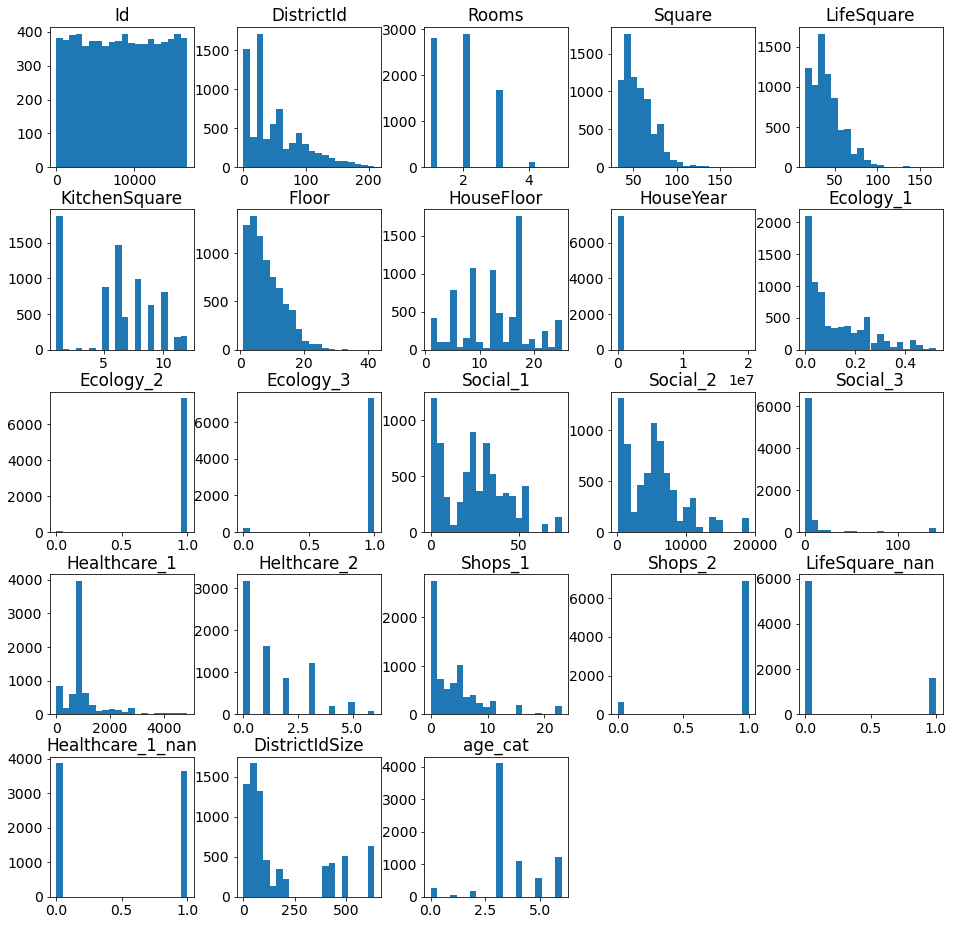

In [8314]:
X_train_num_features.hist(figsize=(16,16), bins=20, grid=False);

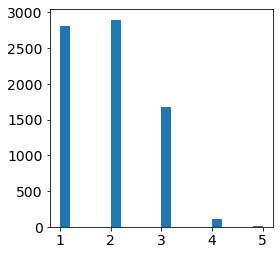

In [8315]:
X_train.loc[X_train['Rooms'] < 10, 'Rooms'].hist(figsize=(4,4), bins=20, grid=False);

In [8316]:
X_train.loc[X_train['Rooms'] < 1, 'Rooms'] = X_train['Rooms'] = 1
X_valid.loc[X_train['Rooms'] < 1, 'Rooms'] = X_train['Rooms'] = 1
test_df.loc[X_train['Rooms'] < 1, 'Rooms'] = X_train['Rooms'] = 1

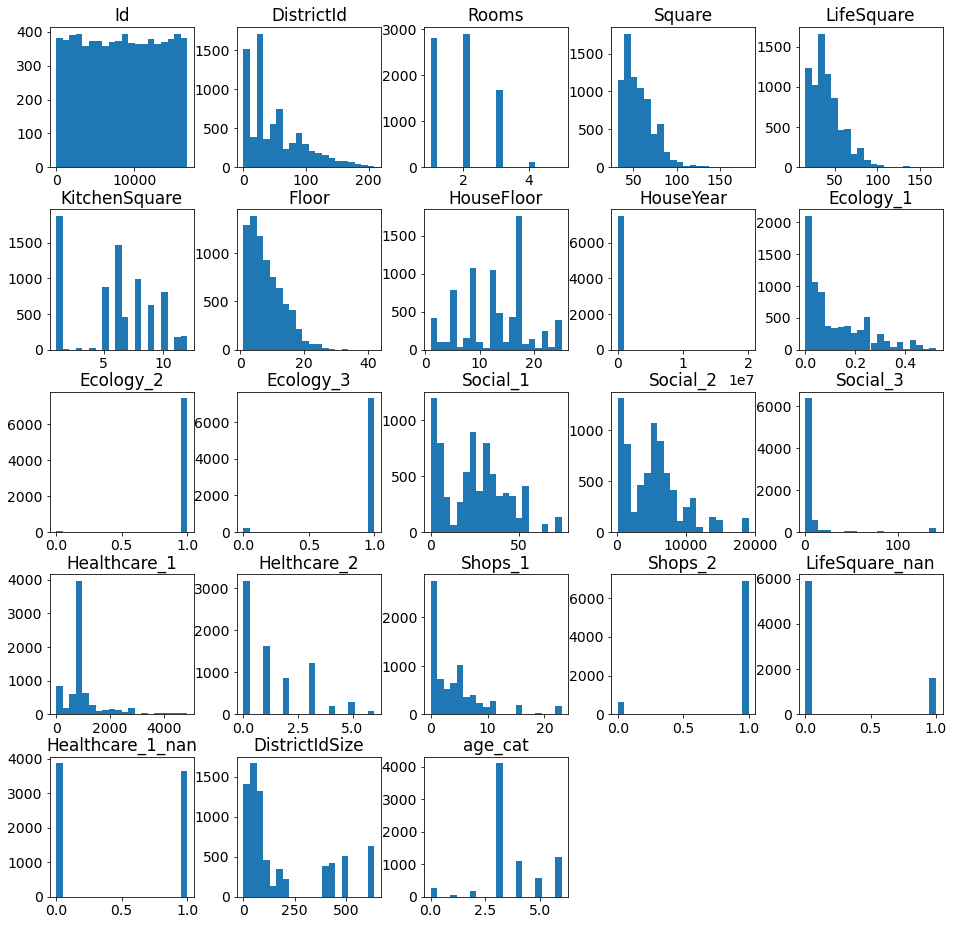

In [8317]:
X_train_num_features.hist(figsize=(16,16), bins=20, grid=False);

<function matplotlib.pyplot.show(close=None, block=None)>

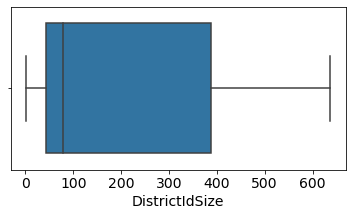

In [8318]:
plt.figure(figsize=(6, 3))

sns.boxplot(X_train['DistrictIdSize'], whis=1.5)
plt.xlabel('DistrictIdSize')
plt.show

In [8319]:
X_train.loc[(X_train['DistrictIdSize'] > 100) | (X_train['DistrictIdSize'] < 60), 'DistrictIdSize'] = X_train['DistrictIdSize'].median()
X_valid.loc[X_valid['DistrictIdSize'] > 100 | (X_valid['DistrictIdSize'] < 60), 'DistrictIdSize'] = X_train['DistrictIdSize'].median()
test_df.loc[test_df['DistrictIdSize'] > 100 | (test_df['DistrictIdSize'] < 60), 'DistrictIdSize'] = X_train['DistrictIdSize'].median()

<function matplotlib.pyplot.show(close=None, block=None)>

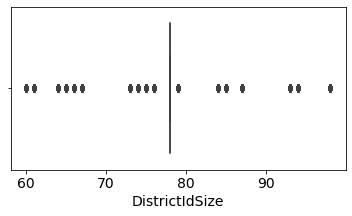

In [8320]:
plt.figure(figsize=(6, 3))

sns.boxplot(X_train['DistrictIdSize'], whis=1.5)
plt.xlabel('DistrictIdSize')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

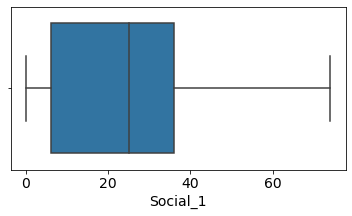

In [8321]:
plt.figure(figsize=(6, 3))

sns.boxplot(X_train['Social_1'], whis=1.5)
plt.xlabel('Social_1')
plt.show

In [8322]:
X_train.loc[(X_train['Social_1'] > 60), 'Social_1'] = X_train['Social_1'].median()
X_valid.loc[X_valid['Social_1'] > 60, 'Social_1'] = X_train['Social_1'].median()
test_df.loc[test_df['Social_1'] > 60, 'Social_1'] = X_train['Social_1'].median()

<function matplotlib.pyplot.show(close=None, block=None)>

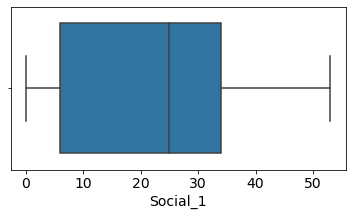

In [8323]:
plt.figure(figsize=(6, 3))

sns.boxplot(X_train['Social_1'], whis=1.5)
plt.xlabel('Social_1')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

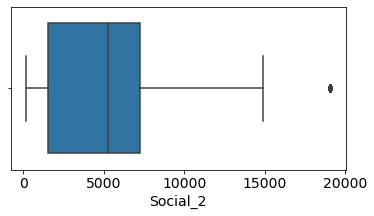

In [8324]:
plt.figure(figsize=(6, 3))

sns.boxplot(X_train['Social_2'], whis=1.5)
plt.xlabel('Social_2')
plt.show

In [8325]:
X_train.loc[(X_train['Social_2'] > 15000), 'Social_2'] = X_train['Social_2'].median()
X_valid.loc[X_valid['Social_2'] > 15000, 'Social_2'] = X_train['Social_2'].median()
test_df.loc[test_df['Social_2'] > 15000, 'Social_2'] = X_train['Social_2'].median()

<function matplotlib.pyplot.show(close=None, block=None)>

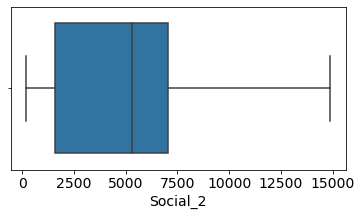

In [8326]:
plt.figure(figsize=(6, 3))

sns.boxplot(X_train['Social_2'], whis=1.5)
plt.xlabel('Social_2')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

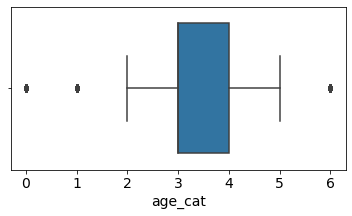

In [8327]:
plt.figure(figsize=(6, 3))

sns.boxplot(X_train['age_cat'], whis=1.5)
plt.xlabel('age_cat')
plt.show

In [8328]:
X_train.loc[(X_train['age_cat'] < 1), 'age_cat'] = X_train['age_cat'].median()
X_valid.loc[X_valid['age_cat'] < 1, 'age_cat'] = X_train['age_cat'].median()
test_df.loc[test_df['age_cat'] < 1, 'age_cat'] = X_train['age_cat'].median()

<function matplotlib.pyplot.show(close=None, block=None)>

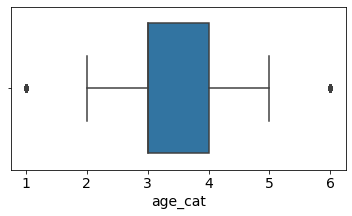

In [8329]:
plt.figure(figsize=(6, 3))

sns.boxplot(X_train['age_cat'], whis=1.5)
plt.xlabel('age_cat')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

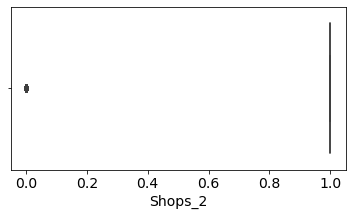

In [8330]:
plt.figure(figsize=(6, 3))

sns.boxplot(X_train['Shops_2'], whis=3)
plt.xlabel('Shops_2')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

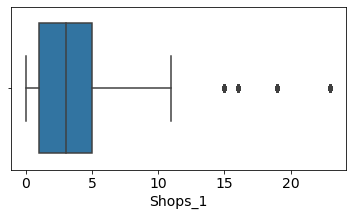

In [8331]:
plt.figure(figsize=(6, 3))

sns.boxplot(X_train['Shops_1'], whis=1.5)
plt.xlabel('Shops_1')
plt.show

In [8332]:
X_train.loc[X_train['Shops_1'] > 17, 'Shops_1'] = X_train['Shops_1'].median()
X_valid.loc[X_valid['Shops_1'] > 17, 'Shops_1'] = X_train['Shops_1'].median()
test_df.loc[test_df['Shops_1'] > 17, 'Shops_1'] = X_train['Shops_1'].median()

<function matplotlib.pyplot.show(close=None, block=None)>

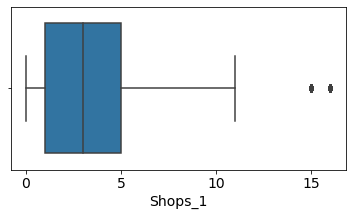

In [8333]:
plt.figure(figsize=(6, 3))

sns.boxplot(X_train['Shops_1'], whis=1.5)
plt.xlabel('Shops_1')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

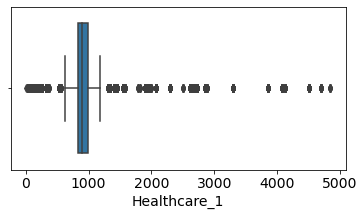

In [8334]:
plt.figure(figsize=(6, 3))

sns.boxplot(X_train['Healthcare_1'], whis=1.5)
plt.xlabel('Healthcare_1')
plt.show

In [8335]:
X_train.loc[(X_train['Healthcare_1'] < 700) | (X_train['Healthcare_1'] > 2800), 'Healthcare_1'] = X_train['Healthcare_1'].median()
X_valid.loc[(X_valid['Healthcare_1'] < 700) | (X_valid['Healthcare_1'] > 2800), 'Healthcare_1'] = X_train['Healthcare_1'].median()
test_df.loc[(test_df['Healthcare_1'] < 700) | (test_df['Healthcare_1'] > 2800) , 'Healthcare_1'] = X_train['Healthcare_1'].median()

<function matplotlib.pyplot.show(close=None, block=None)>

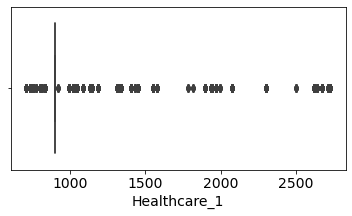

In [8336]:
plt.figure(figsize=(6, 3))

sns.boxplot(X_train['Healthcare_1'], whis=1.5)
plt.xlabel('Healthcare_1')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

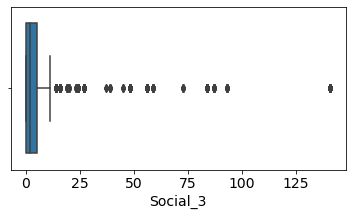

In [8337]:
plt.figure(figsize=(6, 3))

sns.boxplot(X_train['Social_3'], whis=1.5)
plt.xlabel('Social_3')
plt.show

In [8338]:
X_train.loc[X_train['Social_3'] > 90, 'Social_3'] = X_train['Social_3'].median()
X_valid.loc[X_valid['Social_3'] > 90, 'Social_3'] = X_train['Social_3'].median()
test_df.loc[test_df['Social_3'] > 90, 'Social_3'] = X_train['Social_3'].median()

<function matplotlib.pyplot.show(close=None, block=None)>

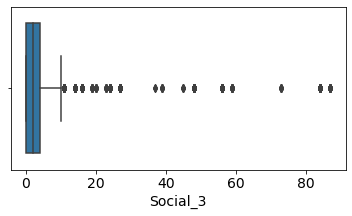

In [8339]:
plt.figure(figsize=(6, 3))

sns.boxplot(X_train['Social_3'], whis=1.5)
plt.xlabel('Social_3')
plt.show

### Уменьшение размера

In [8340]:
def reduce_mem_usage(X_train):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = X_train.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in X_train.columns:
        col_type = X_train[col].dtype
        
        if col_type != object:
            c_min = X_train[col].min()
            c_max = X_train[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    X_train[col] = X_train[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    X_train[col] = X_train[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    X_train[col] = X_train[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    X_train[col] = X_train[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    X_train[col] = X_train[col].astype(np.float32)
                else:
                    X_train[col] = X_train[col].astype(np.float64)
        else:
            X_train[col] = X_train[col].astype('category')

    end_mem = X_train.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return X_train

In [8341]:
X_train = reduce_mem_usage(X_train)

Memory usage of dataframe is 1.60 MB
Memory usage after optimization is: 0.65 MB
Decreased by 59.6%


In [8342]:
def reduce_mem_usage(X_valid):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = X_valid.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in X_valid.columns:
        col_type = X_valid[col].dtype
        
        if col_type != object:
            c_min = X_valid[col].min()
            c_max = X_valid[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    X_valid[col] = X_valid[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    X_valid[col] = X_valid[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    X_valid[col] = X_valid[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    X_valid[col] = X_validn[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    X_valid[col] = X_valid[col].astype(np.float32)
                else:
                    X_valid[col] = X_valid[col].astype(np.float64)
        else:
            X_valid[col] = X_validn[col].astype('category')

    end_mem = X_valid.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return X_valid

In [8343]:
X_valid = reduce_mem_usage(X_valid)

Memory usage of dataframe is 0.45 MB
Memory usage after optimization is: 0.13 MB
Decreased by 70.2%


In [8344]:
def reduce_mem_usage(test_df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = test_df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in test_df.columns:
        col_type = test_df[col].dtype
        
        if col_type != object:
            c_min = test_df[col].min()
            c_max = test_df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    test_df[col] = test_df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    test_df[col] = test_df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    test_df[col] = test_df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    test_df[col] = test_df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    test_df[col] = test_df[col].astype(np.float32)
                else:
                    test_df[col] = test_df[col].astype(np.float64)
        else:
            test_df[col] = test_df[col].astype('category')

    end_mem = test_df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return test_df

### Построение модели

#### Обучение 

#### RandomForestRegressor

In [8345]:
model = RandomForestRegressor(n_estimators=500, max_depth=12, max_features=8, random_state=42)

In [8346]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, max_features=8, n_estimators=500,
                      random_state=42)

In [8347]:
y_pred_model_train = model.predict(X_train)
y_pred_model_train.shape

(7500,)

In [8348]:
y_pred_model = model.predict(X_valid)
y_pred_model.shape

(2500,)

In [8349]:
check_test = pd.DataFrame({'y_valid': y_valid, 'y_pred_model': y_pred_model.flatten()})
check_test.head(10)

,y_valid,y_pred_model
6252,225202.099645,299619.431613
4684,361744.269547,266130.780337
1731,275055.182201,223889.794560
4742,198133.702204,182904.557397
4521,221299.460377,165580.560749
6340,221920.853310,225473.602804
576,362498.306762,341843.644967
5202,185991.006440,169958.307159
6363,185230.373774,177785.922636
439,154170.219034,175107.994546


In [8350]:
check_test["error"] = check_test["y_valid"] - check_test["y_pred_model"]
check_test.head(10)

,y_valid,y_pred_model,error
6252,225202.099645,299619.431613,-74417.331968
4684,361744.269547,266130.780337,95613.489210
1731,275055.182201,223889.794560,51165.387641
4742,198133.702204,182904.557397,15229.144807
4521,221299.460377,165580.560749,55718.899628
6340,221920.853310,225473.602804,-3552.749494
576,362498.306762,341843.644967,20654.661795
5202,185991.006440,169958.307159,16032.699281
6363,185230.373774,177785.922636,7444.451138
439,154170.219034,175107.994546,-20937.775512


#### Оценка модели

In [8351]:
r2_score_2 = r2(y_train, y_pred_model_train)
r2_score_2

0.897583902452097

In [8352]:
r2_score_1 = r2(y_valid, y_pred_model)
r2_score_1

0.7380184815081705

R2:	0.738
RMSE:	48928.02
MSE:	2393951161.331


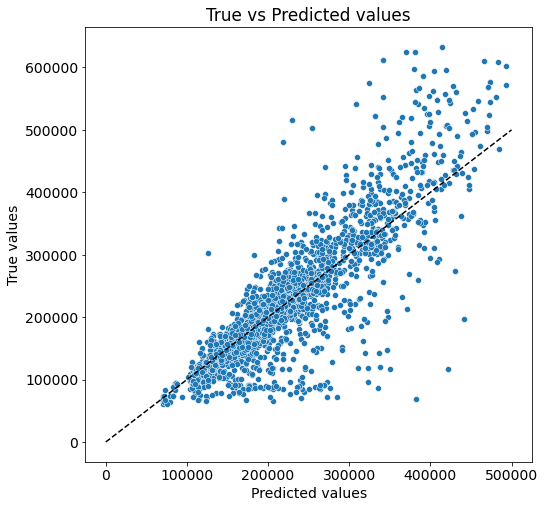

In [8353]:
evaluate_preds(np.squeeze(y_valid.values), y_pred_model)

#### Кросс-валидация

In [8354]:
cv_score = cross_val_score(model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.70886903, 0.73099001, 0.71832611])

In [8355]:
cv_score.mean()

0.7193950515119724

#### Важность признаков

In [8356]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
3,Square,0.367356
4,LifeSquare,0.105756
13,Social_2,0.087259
12,Social_1,0.085612
14,Social_3,0.074871
1,DistrictId,0.043626
9,Ecology_1,0.035679
5,KitchenSquare,0.031963
8,HouseYear,0.031392
16,Helthcare_2,0.021159


#### Прогнозирование на тестовом датасете

In [8357]:
test_df.shape

(5000, 23)

In [8358]:
sample_submission = pd.read_csv(sample_submission, sep=',')
sample_submission.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [8359]:
predictions = model.predict(test_df)
predictions

array([159602.07783665, 120579.70532426, 144713.08355947, ...,
       151071.06169976, 187415.87652161, 258587.8888257 ])

#### Запись и сохранение результатов

In [8360]:
sample_submission['Price'] = predictions
sample_submission.head()

,Id,Price
0,4567,159602.077837
1,5925,120579.705324
2,960,144713.083559
3,3848,119044.615423
4,746,222838.766363


In [8361]:
sample_submission.to_csv(r'C:\Users\Виктория\Downloads\Библиотеки питон\курсач\sample_submission2.csv', index=False)